In [1]:
!pip install datasets==2.19.1 nltk evaluate tqdm bert_score wandb torch transformers sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
import torch
from transformers import MarianMTModel, MarianTokenizer, M2M100ForConditionalGeneration, M2M100Tokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm

In [3]:
# Load evaluation metrics
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [50]:
# Load dataset
dataset = load_dataset("wmt14", "de-en")
samples = dataset["test"].select(range(100))
src_texts = [item["translation"]["en"] for item in samples]
references = [item["translation"]["de"] for item in samples]

In [51]:
# Load models and tokenizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

marian_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-de").to(device)
marian_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")

m2m_model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M").to(device)
m2m_tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [52]:
def compute_metrics(predictions, references):
    # Wrap references as list of list of strings as required by evaluate
    wrapped_references = [[ref] for ref in references]

    bleu_score = bleu.compute(predictions=predictions, references=wrapped_references)["bleu"]
    meteor_score = meteor.compute(predictions=predictions, references=wrapped_references)["meteor"]

    bert_scores = bertscore.compute(predictions=predictions, references=wrapped_references, lang="de")

    bert_precision_avg = sum(bert_scores["precision"]) / len(bert_scores["precision"])
    bert_recall_avg = sum(bert_scores["recall"]) / len(bert_scores["recall"])
    bert_f1_avg = sum(bert_scores["f1"]) / len(bert_scores["f1"])

    return bleu_score, meteor_score, bert_precision_avg, bert_recall_avg, bert_f1_avg




In [53]:
# Store results
records = []

for i in tqdm(range(len(src_texts)), desc="Evaluating samples"):
    src, ref = src_texts[i], references[i]

    # MarianMT translation
    inputs = marian_tokenizer([src], return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = marian_model.generate(**inputs, num_beams=4)
    marian_translation = marian_tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # M2M100 translation
    m2m_tokenizer.src_lang = "en"
    m2m_inputs = m2m_tokenizer(src, return_tensors="pt").to(device)
    forced_bos_token_id = m2m_tokenizer.get_lang_id("de")
    m2m_output = m2m_model.generate(**m2m_inputs, forced_bos_token_id=forced_bos_token_id)
    m2m_translation = m2m_tokenizer.batch_decode(m2m_output, skip_special_tokens=True)[0]

    # Compute metrics in batch style, one prediction and one reference wrapped in lists
    marian_metrics = compute_metrics([marian_translation], [ref])
    m2m_metrics = compute_metrics([m2m_translation], [ref])

    metrics_names = ["BLEU", "METEOR", "BERT Precision", "BERT Recall", "BERT F1"]
    for metric, mar_val, m2m_val in zip(metrics_names, marian_metrics, m2m_metrics):
        records.append({"Metric": metric, "Model": "MarianMT", "Score": mar_val, "Index": i})
        records.append({"Metric": metric, "Model": "M2M100", "Score": m2m_val, "Index": i})
    # Print each example
    print(f"\nExample {i+1}")
    print(f"Source: {src}")
    print(f"Reference: {ref}")
    print(f"MarianMT: {marian_translation}")
    print(f"M2M100:  {m2m_translation}")

Evaluating samples:   1%|          | 1/100 [00:00<00:49,  2.01it/s]


Example 1
Source: Gutach: Increased safety for pedestrians
Reference: Gutach: Noch mehr Sicherheit für Fußgänger
MarianMT: Gutach: Mehr Sicherheit für Fußgänger
M2M100:  Gutach: Sicherheit für Fußgänger erhöht


Evaluating samples:   2%|▏         | 2/100 [00:02<01:48,  1.10s/it]


Example 2
Source: They are not even 100 metres apart: On Tuesday, the new B 33 pedestrian lights in Dorfparkplatz in Gutach became operational - within view of the existing Town Hall traffic lights.
Reference: Sie stehen keine 100 Meter voneinander entfernt: Am Dienstag ist in Gutach die neue B 33-Fußgängerampel am Dorfparkplatz in Betrieb genommen worden - in Sichtweite der älteren Rathausampel.
MarianMT: Sie sind nicht einmal 100 Meter voneinander entfernt: Am Dienstag wurde die neue B 33 am Dorfparkplatz in Gutach in Betrieb genommen - mit Blick auf die bestehende Rathausampeln.
M2M100:  Sie sind nicht einmal 100 Meter entfernt: Am Dienstag wurden die neuen B-33 Fußgängerleuchten im Dorfparkplatz in Gutach in Betrieb - im Blick auf die bestehenden Straßenverkehrsleuchten.


Evaluating samples:   3%|▎         | 3/100 [00:02<01:27,  1.11it/s]


Example 3
Source: Two sets of lights so close to one another: intentional or just a silly error?
Reference: Zwei Anlagen so nah beieinander: Absicht oder Schildbürgerstreich?
MarianMT: Zwei Lichter so nah aneinander: absichtlich oder einfach nur ein dummer Fehler?
M2M100:  Zwei Sätze von Licht so nah miteinander: absichtlich oder einfach ein dummes Fehler?


Evaluating samples:   4%|▍         | 4/100 [00:03<01:13,  1.31it/s]


Example 4
Source: Yesterday, Gutacht's Mayor gave a clear answer to this question.
Reference: Diese Frage hat Gutachs Bürgermeister gestern klar beantwortet.
MarianMT: Gestern gab Gutachts Bürgermeister eine klare Antwort auf diese Frage.
M2M100:  Gestern gab der Bürgermeister von Gutacht eine klare Antwort auf diese Frage.


Evaluating samples:   5%|▌         | 5/100 [00:04<01:18,  1.21it/s]


Example 5
Source: "At the time, the Town Hall traffic lights were installed because this was a school route," explained Eckert yesterday.
Reference: "Die Rathausampel ist damals installiert worden, weil diese den Schulweg sichert", erläuterte Eckert gestern.
MarianMT: "Damals wurden die Rathausampeln installiert, weil dies eine Schulroute war", erklärte Eckert gestern.
M2M100:  "In der Zeit wurden die Straßenbeleuchtungen im Stadthall installiert, weil dies eine Schulroute war", erklärte Eckert gestern.


Evaluating samples:   6%|▌         | 6/100 [00:05<01:19,  1.19it/s]


Example 6
Source: The Kluser lights protect cyclists, as well as those travelling by bus and the residents of Bergle.
Reference: Die Kluser-Ampel sichere sowohl Radfahrer als auch Busfahrgäste und die Bergle-Bewohner.
MarianMT: Die Kluser Lichter schützen Radfahrer, aber auch Reisende mit dem Bus und die Bewohner von Bergle.
M2M100:  Die Kluser-Lichter schützen Fahrräder sowie diejenigen, die mit dem Bus und den Bewohnern von Bergle reisen.


Evaluating samples:   7%|▋         | 7/100 [00:05<01:20,  1.16it/s]


Example 7
Source: The system, which officially became operational yesterday, is of importance to the Sulzbachweg/Kirchstrasse junction.
Reference: Die gestern offiziell in Betrieb genommene Anlage sei wichtig für den Kreuzungsbereich Sulzbachweg/Kirchstraße.
MarianMT: Das System, das gestern offiziell in Betrieb genommen wurde, ist für den Sulzbachweg/Kirchstraße von Bedeutung.
M2M100:  Das System, das offiziell gestern in Betrieb wurde, ist von Bedeutung für die Sulzbachweg/Kirchstrasse-Junktion.


Evaluating samples:   8%|▊         | 8/100 [00:07<01:32,  1.00s/it]


Example 8
Source: We have the museum, two churches, the spa gardens, the bus stop, a doctor's practice and a bank, not to mention the traffic from the 'Grub' residential area.
Reference: Wir haben das Museum, zwei Kirchen, Kurpark, die Bushaltestelle, einen Arzt und eine Bank sowie den Verkehrsfluss aus dem Wohngebiet ›Grub‹.
MarianMT: Wir haben das Museum, zwei Kirchen, die Kurgärten, die Bushaltestelle, eine Arztpraxis und eine Bank, ganz zu schweigen von dem Verkehr aus dem 'Grub' Wohngebiet.
M2M100:  Wir haben das Museum, zwei Kirchen, die Spa-Gärten, die Bushaltestelle, eine Arztpraxis und eine Bank, um nicht zu erwähnen, den Verkehr aus der "Grub" Wohngebiet.


Evaluating samples:   9%|▉         | 9/100 [00:08<01:32,  1.02s/it]


Example 9
Source: "At times of high road and pedestrian traffic, an additional set of lights were required to ensure safety," said Eckert.
Reference: "Bei dem hohen Verkehrs- und Fußgängeraufkommen musste zu deren Sicherheit eine weitere Ampel her", so Eckert.
MarianMT: "In Zeiten des hohen Straßen- und Fußgängerverkehrs waren zusätzliche Lichter erforderlich, um die Sicherheit zu gewährleisten", sagte Eckert.
M2M100:  "In Zeiten des Hochstraßen- und Fußgängerverkehrs wurde ein zusätzliches Set von Lichter benötigt, um die Sicherheit zu gewährleisten", sagte Eckert.


Evaluating samples:  10%|█         | 10/100 [00:08<01:17,  1.16it/s]


Example 10
Source: This was also confirmed by Peter Arnold from the Offenburg District Office.
Reference: Dies bestätigt auch Peter Arnold vom Landratsamt Offenburg.
MarianMT: Dies wurde auch von Peter Arnold vom Amtsbezirk Offenburg bestätigt.
M2M100:  Das bestätigte auch Peter Arnold vom Offenburg District Office.


Evaluating samples:  11%|█         | 11/100 [00:10<01:26,  1.03it/s]


Example 11
Source: "According to current measurements, around 12,000 vehicles travel through the town of Gutach on the B33 on a daily basis, of which heavy goods traffic accounts for around ten per cent," emphasised Arnold.
Reference: "Laut aktuellen Messungen durchfahren auf der B 33 täglich etwa 12 000 Fahrzeuge die Gemeinde Gutach, davon sind etwa zehn Prozent Schwerlastverkehr", betont Arnold.
MarianMT: "Nach aktuellen Messungen fahren täglich rund 12.000 Fahrzeuge auf der B33 durch die Stadt Gutach, von denen der Schwerlastverkehr rund zehn Prozent ausmacht", betonte Arnold.
M2M100:  "Nach den aktuellen Messungen reisen rund 12.000 Fahrzeuge durch die Stadt Gutach auf dem B33 täglich, von denen schweres Güterverkehr etwa zehn Prozent beträgt", betonte Arnold.


Evaluating samples:  12%|█▏        | 12/100 [00:11<01:34,  1.07s/it]


Example 12
Source: Therefore the construction of an additional set of lights was more than necessary: "Here safety comes first, it's that simple," said Arnold.
Reference: Daher sei der Bau einer weiteren Ampel mehr als notwendig: "Sicherheit geht hier einfach vor", so Arnold.
MarianMT: Deshalb war der Bau eines zusätzlichen Lichtersatzes mehr als notwendig: "Hier kommt die Sicherheit an erster Stelle, so einfach ist es", sagte Arnold.
M2M100:  Daher war die Konstruktion eines zusätzlichen Lichts mehr als notwendig: "Hier kommt die Sicherheit zuerst, es ist so einfach", sagte Arnold.


Evaluating samples:  13%|█▎        | 13/100 [00:13<01:50,  1.27s/it]


Example 13
Source: A total of four road safety inspections were carried out and a roundabout was also considered, however, this idea was rejected on account of the narrowness of the Sulzbachweg/Kirchstrasse junctions.
Reference: Insgesamt seien vier Verkehrsschauen durchgeführt worden, auch ein Kreisverkehr wurde angedacht, allerdings wegen der Enge in dem Kreuzungsbereich Sulzbachweg/Kirchstraße wieder verworfen.
MarianMT: Insgesamt wurden vier Verkehrssicherheitsinspektionen durchgeführt und auch ein Kreisverkehr in Betracht gezogen, der jedoch aufgrund der Enge der Kreuzungen Sulzbachweg/Kirchstraße abgelehnt wurde.
M2M100:  Insgesamt wurden vier Straßensicherheitsinspektionen durchgeführt und ein Rundabout wurde ebenfalls berücksichtigt, jedoch wurde diese Idee aufgrund der engen Zusammenhänge der Sulzbachweg/Kirchstrasse abgelehnt.


Evaluating samples:  14%|█▍        | 14/100 [00:15<02:10,  1.52s/it]


Example 14
Source: According to Arnold, every possible test was carried out prior to the selection of the location for the traffic light posts: "Using a goods vehicle loaded with particularly long tree trunks, we also tested whether such vehicles could access the B 33 from the Sulzbachweg without knocking over the traffic light posts".
Reference: Es wurde laut Arnold bei der Standortwahl der Ampelmasten zuvor alles ausgetestet: "Mittels eines extra für uns mit besonders langen Holzstämmen beladener Transporter haben wir ausgestestet, ob diese Fahrzeuge aus dem Sulzbachweg auf die B 33 ausfahren können, ohne den Ampelmasten umzuknicken".
MarianMT: Vor der Auswahl des Standorts für die Ampelpfosten wurde laut Arnold jeder mögliche Test durchgeführt: "Mit einem mit besonders langen Baumstämmen beladenen Güterwagen haben wir auch getestet, ob solche Fahrzeuge vom Sulzbachweg aus auf die B 33 gelangen konnten, ohne die Ampelpfosten zu überfallen."
M2M100:  Nach Angaben von Arnold wurden al

Evaluating samples:  15%|█▌        | 15/100 [00:16<01:55,  1.35s/it]


Example 15
Source: The traffic light system itself, which cost around EUR 15,000, is the "most modern system that is currently available on the market," explained Arnold.
Reference: Die rund 15 000 Euro teure Ampelanlage selbst ist das "modernste, was es derzeit auf dem Markt gibt", erläuterte Arnold.
MarianMT: Das rund 15.000 Euro teure Ampelsystem selbst ist das "modernste System, das derzeit auf dem Markt verfügbar ist", erklärt Arnold.
M2M100:  Das Verkehrslichtsystem selbst, das rund 15.000 Euro kostet, ist "das modernste System, das derzeit auf dem Markt verfügbar ist", erklärte Arnold.


Evaluating samples:  16%|█▌        | 16/100 [00:17<01:46,  1.27s/it]


Example 16
Source: The system is fitted with coloured LEDs, which are bright enough that drivers can easily see the lights, even when the sun is low in the sky.
Reference: Die Anlage ist mit farbigen LEDs ausgestattet, die so kräftig leuchten, dass die Lichter von den Autofahrern beispielsweise auch bei tiefstehender Sonne gut zu erkennen sind.
MarianMT: Das System ist mit farbigen LEDs ausgestattet, die hell genug sind, dass die Fahrer die Lichter leicht sehen können, auch wenn die Sonne am Himmel niedrig ist.
M2M100:  Das System ist mit farbigen LEDs ausgestattet, die klar genug sind, damit Fahrer die Lichter leicht sehen können, auch wenn die Sonne im Himmel niedrig ist.


Evaluating samples:  17%|█▋        | 17/100 [00:18<01:34,  1.14s/it]


Example 17
Source: And they are also energy-efficient: The older light systems consume around 100 Watts, with the new ones consuming just eight.
Reference: Und sparsam ist sie auch: Die älteren Lichtanlagen verbrauchen etwa 100 Watt, die neuen gerade mal acht Watt.
MarianMT: Und sie sind auch energieeffizient: Die älteren Lichtsysteme verbrauchen rund 100 Watt, die neuen nur acht.
M2M100:  Und sie sind auch energieeffizient: Die älteren Lichtsysteme verbrauchen rund 100 Watt, die neuen verbrauchen nur acht.


Evaluating samples:  18%|█▊        | 18/100 [00:18<01:15,  1.09it/s]


Example 18
Source: There are three sets of lights per direction of travel.
Reference: Pro Fahrtrichtung gibt es drei Lichtanlagen.
MarianMT: Es gibt drei Lichtersätze pro Fahrtrichtung.
M2M100:  Es gibt drei Sätze von Lichter pro Reiseziel.


Evaluating samples:  19%|█▉        | 19/100 [00:19<01:09,  1.16it/s]


Example 19
Source: Arnold explained the technology used by the new system: It is fitted with two radar sensors.
Reference: Arnold erklärte die Technik der neuen Anlage: Diese ist mit zwei Radarsensoren ausgestattet.
MarianMT: Arnold erläuterte die Technologie des neuen Systems: Es ist mit zwei Radarsensoren ausgestattet.
M2M100:  Arnold erklärte die von dem neuen System verwendete Technologie: Es ist mit zwei Radar-Sensoren ausgestattet.


Evaluating samples:  20%|██        | 20/100 [00:20<01:09,  1.15it/s]


Example 20
Source: If the pedestrian presses the button at the traffic lights, the top radar sensor checks the traffic status.
Reference: Drückt der Fußgänger den Ampelknopf, testet der obere Radarsensor die Verkehrslage.
MarianMT: Wenn der Fußgänger die Taste an der Ampel drückt, überprüft der obere Radarsensor den Verkehrszustand.
M2M100:  Wenn der Fußgänger den Button bei den Verkehrslicht drückt, überprüft der obere Radar-Sensor den Verkehrsstatus.


Evaluating samples:  21%|██        | 21/100 [00:21<01:11,  1.11it/s]


Example 21
Source: If the street is clear, the pedestrian obtains a green light immediately, if not, there is a delay of around 15 seconds.
Reference: Ist die Straße frei, kommt unmittelbar Grün für den Fußgänger, wenn nicht, dauert es etwa 15 Sekunden.
MarianMT: Wenn die Straße frei ist, erhält der Fußgänger sofort ein grünes Licht, wenn nicht, gibt es eine Verzögerung von etwa 15 Sekunden.
M2M100:  Wenn die Straße klar ist, erhält der Fußgänger sofort ein grünes Licht, wenn nicht, gibt es eine Verzögerung von ca. 15 Sekunden.


Evaluating samples:  22%|██▏       | 22/100 [00:21<01:06,  1.16it/s]


Example 22
Source: An additional radar sensor checks whether the green phase for the pedestrian can be ended.
Reference: Ein weiteres Radarsensor prüft, ob die Grünphase für den Fußgänger beendet werden kann.
MarianMT: Ein zusätzlicher Radarsensor prüft, ob die grüne Phase für den Fußgänger beendet werden kann.
M2M100:  Ein zusätzlicher Radar-Sensor überprüft, ob die grüne Phase für den Fußgänger abgeschlossen werden kann.


Evaluating samples:  23%|██▎       | 23/100 [00:23<01:21,  1.06s/it]


Example 23
Source: "If a group of people or if disabled persons are crossing the street, the green phase is extended, thus ensuring that everyone gets safely across the street," explained Arnold.
Reference: "Sollte eine Gruppe oder gehbehinderte Menschen über die Straße gehen, wird die Grünphase verlängert, es kommt also jeder sicher über die Fahrbahn", erklärte Arnold.
MarianMT: "Wenn eine Gruppe von Menschen oder behinderte Menschen die Straße überqueren, wird die grüne Phase verlängert und so sichergestellt, dass alle sicher über die Straße kommen", erklärte Arnold.
M2M100:  "Wenn eine Gruppe von Menschen oder Menschen mit Behinderungen die Straße überschreiten, wird die grüne Phase erweitert, um sicherzustellen, dass alle sicher über die Straße kommen", erklärte Arnold.


Evaluating samples:  24%|██▍       | 24/100 [00:24<01:14,  1.01it/s]


Example 24
Source: Of course, drivers must also play their part and keep their eyes on the road.
Reference: Natürlich müsse der Autofahrer hier als Partner mitdenken und die Fahrbahn beobachten.
MarianMT: Selbstverständlich müssen die Fahrer auch ihren Teil dazu beitragen und die Straße im Auge behalten.
M2M100:  Selbstverständlich müssen Fahrer auch ihre Rolle spielen und ihre Augen auf der Straße halten.


Evaluating samples:  25%|██▌       | 25/100 [00:25<01:17,  1.03s/it]


Example 25
Source: Yesterday this was not the case: The light had barely turned green for pedestrians when a luxury vehicle sped through on a red light.
Reference: Dies war gestern nicht der Fall: Kaum zeigte die Ampel für Fußgänger grün, rauschte ein Oberklasse-Fahrzeug durch - bei leuchtendem Rot.
MarianMT: Gestern war das nicht der Fall: Das Licht war für Fußgänger kaum grün geworden, als ein Luxusfahrzeug an einer roten Ampel durchfuhr.
M2M100:  Gestern war dies nicht der Fall: Das Licht war kaum für Fußgänger grün geworden, als ein luxuriöses Fahrzeug auf einem roten Licht durchspann.


Evaluating samples:  26%|██▌       | 26/100 [00:26<01:10,  1.04it/s]


Example 26
Source: For more than 30 years, Josef Winkler has been writing from the heart, telling of the hardships of his childhood and youth.
Reference: Josef Winkler schreibt sich seit mehr als 30 Jahren die Nöte seiner Kindheit und Jugend von der Seele.
MarianMT: Seit mehr als 30 Jahren schreibt Josef Winkler aus dem Herzen und erzählt von den Härten seiner Kindheit und Jugend.
M2M100:  Seit mehr als 30 Jahren schreibt Josef Winkler aus dem Herzen über die Schwierigkeiten seiner Kindheit und Jugend.


Evaluating samples:  27%|██▋       | 27/100 [00:27<01:25,  1.17s/it]


Example 27
Source: The catastrophes of his Catholic village upbringing - the speechlessness, his tendency towards brute force and dulled sexuality, the confinement and lack of joy - all of this has been described many times by the Kaernten-born poet.
Reference: Die Katastrophen seiner katholischen Dorfkindheit - die Sprachlosigkeit, der Hang zu roher Gewalt und stumpfer Sexualität, die Enge und Freudlosigkeit - hat der Kärntner Dichter vielfach beschrieben.
MarianMT: Die Katastrophen seiner katholischen Dorfaufzucht - die Sprachlosigkeit, seine Tendenz zu brutaler Gewalt und abgestumpfter Sexualität, die Eingeschränktheit und das Fehlen von Freude - das alles hat der in Kaernten geborene Dichter schon oft beschrieben.
M2M100:  Die Katastrophen seines katholischen Dorfes - seine Sprachlosigkeit, seine Tendenz zu brutaler Gewalt und verrückter Sexualität, die Begrenzung und Mangel an Freude - all dies wurde mehrmals von dem Kaernten-geborenen Dichter beschrieben.


Evaluating samples:  28%|██▊       | 28/100 [00:28<01:19,  1.10s/it]


Example 28
Source: The Büchner prizewinner is known primarily as a writer of prose, with theatre texts something of a rarity for him.
Reference: Bekannt ist der Büchner-Preisträger vor allem als Prosaautor, Theatertexte sind in seinem Werk rar.
MarianMT: Der Büchner-Preisträger ist vor allem als Prosaautor bekannt, mit Theatertexten für ihn eine Seltenheit.
M2M100:  Der Büchner Prizewinner ist hauptsächlich als Proza-Schriftsteller bekannt, mit Theatertexten etwas seltenes für ihn.


Evaluating samples:  29%|██▉       | 29/100 [00:30<01:34,  1.33s/it]


Example 29
Source: In a collage of prose texts For his performance piece, "Wetterleuchten auf der Zungenspitze" (Summer lightning on the tip of your tongue), which can now be seen in Garage X on Petersplatz, Gerhard Fresacher ,creates a collage of prose texts.
Reference: Collage aus Prosatexten Gerhard Fresacher stellt für seine Aufführung "Wetterleuchten auf der Zungenspitze", die nun in der Garage X am Petersplatz zu sehen ist, daher eine Collage aus Prosatexten zusammen.
MarianMT: In einer Collage aus Prosatexten Für sein Performancestück "Wetterleuchten auf der Zungenspitze", das nun in Garage X am Petersplatz, Gerhard Fresacher, zu sehen ist, entsteht eine Collage aus Prosatexten.
M2M100:  In einer Kollage von Prose-Texten Für sein Ausstellungsstück, "Wetterleuchten auf der Zungenspitze" (Summerlicht am Spitze deiner Zunge), die jetzt in Garage X auf Petersplatz, Gerhard Fresacher gesehen werden kann, schafft eine Kollage von Prose-Texten.


Evaluating samples:  30%|███       | 30/100 [00:32<01:42,  1.47s/it]


Example 30
Source: The theatre producer has thus combined elements from the autobiographically inspired novel "Der Leibeigene" (1987) [The Bondsman] featuring prose miniatures from "Leichnam, seine Familie belauernd" (2003) [Corpse, stalking his family].
Reference: Der Theatermacher verbindet etwa Elemente aus dem autobiografisch geprägten Roman "Der Leibeigene" (1987) mit Prosaminiaturen aus "Leichnam, seine Familie belauernd" (2003).
MarianMT: So hat der Theaterproduzent Elemente aus dem autobiografisch inspirierten Roman "Der Leibigene" (1987) [Der Bondsman] mit Prosa-Miniaturen aus "Leihnam, seine Familie belauernd" (2003) [Corpse, stalkt seine Familie] kombiniert.
M2M100:  Der Theaterproduzenten hat so Elemente aus dem autobiographisch inspirierten Roman "Der Leibeigene" (1987) [The Bondsman] mit prozen Miniaturen aus "Leichnam, seine Familie belauernd" (2003) [Corpse, stalking seine Familie].


Evaluating samples:  31%|███       | 31/100 [00:33<01:42,  1.49s/it]


Example 31
Source: On the predominantly empty stage - with one important requirement: a crumpled sofa, on which cast members allude to copulating and masturbating - the eight-person ensemble work their way through the text material.
Reference: Auf der weitgehend leergeräumten Bühne - wichtiges Requisit: ein zerknautschtes Sofa, auf dem andeutungsweise kopuliert und masturbiert wird - hangelt sich das achtköpfige Ensemble durch das Textmaterial.
MarianMT: Auf der überwiegend leeren Bühne - mit einer wichtigen Anforderung: einem zerknitterten Sofa, auf dem die Besetzungsmitglieder auf Kopulieren und Masturbieren anspielen - arbeitet sich das achtköpfige Ensemble durch das Textmaterial aus.
M2M100:  In der überwiegend leeren Phase - mit einer wichtigen Anforderung: einem zerbrochenen Sofa, auf dem die Kastenmitglieder auf Kopulation und Masturbation hinweisen - arbeitet das achtpersönliche Ensemble durch das Textmaterial.


Evaluating samples:  32%|███▏      | 32/100 [00:34<01:22,  1.21s/it]


Example 32
Source: However, Director Fresacher seems to have little trust in the text.
Reference: Dabei scheint Regisseur Fresacher dem Text wenig zu vertrauen.
MarianMT: Allerdings scheint Direktor Fresacher wenig Vertrauen in den Text zu haben.
M2M100:  Der Regisseur Fresacher scheint jedoch wenig Vertrauen in den Text zu haben.


Evaluating samples:  33%|███▎      | 33/100 [00:35<01:26,  1.29s/it]


Example 33
Source: The 70-minute performance glosses over the script with a host of director's additions, well-known from the repertoire of post-dramatic theatrical styles.
Reference: Die 70-minütige Performance übertüncht die Vorlage mit einer Fülle an Regieeinfällen, bekannt aus dem Repertoire postdramatischer Spielformen.
MarianMT: Die 70-minütige Performance glänzt über das Drehbuch mit einer Vielzahl von Regisseur-Zusätzen, die aus dem Repertoire der postdramatischen Theaterstile bekannt sind.
M2M100:  Die 70-minütige Performance glänzt über das Szenario mit einer Reihe von Regisseur-Additionen, bekannt aus dem Repertoire von postdramatischen Theaterstilen.


Evaluating samples:  34%|███▍      | 34/100 [00:36<01:16,  1.16s/it]


Example 34
Source: In particular, the actresses play a major role in the sometimes rather dubious staging.
Reference: Vor allem die Schauspielerinnen kommen bei den mitunter etwas fragwürdigen szenischen Umsetzungen dran.
MarianMT: Insbesondere spielen die Schauspielerinnen eine wichtige Rolle in der manchmal eher zweifelhaften Inszenierung.
M2M100:  Insbesondere spielen die Schauspieler eine wichtige Rolle in der manchmal ziemlich zweifelhaften Stage.


Evaluating samples:  35%|███▌      | 35/100 [00:37<01:08,  1.06s/it]


Example 35
Source: They are manhandled, their heads held under water, tacked to the wall by their evening gowns.
Reference: Sie werden hart angefasst, mit dem Kopf unter Wasser getaucht, mit ihren Abendroben an die Wand getackert.
MarianMT: Sie werden mit Handgriffen behandelt, ihre Köpfe unter Wasser gehalten, durch ihre Abendkleider an die Wand geheftet.
M2M100:  Sie sind gehandelt, ihre Köpfe unter Wasser gehalten, mit ihren Abendgötzen an die Wand berührt.


Evaluating samples:  36%|███▌      | 36/100 [00:38<01:14,  1.16s/it]


Example 36
Source: Wrapped in cellophane or in girdles, they stumble on dangerously high heels across the set, either delivering monologues at the top of their voices or lying completely silent on the stage.
Reference: Eingezwängt in Zellophan oder Mieder, staksen sie auf gefährlich hohen Stöckeln durch die Inszenierung, entweder monologisieren sie lautstark oder liegen völlig verstummt auf dem Bühnenboden.
MarianMT: Gewickelt in Cellophan oder in Gürteln stolpern sie auf gefährlich hohen Fersen über das Set und liefern entweder Monologe an der Spitze ihrer Stimmen oder liegen völlig still auf der Bühne.
M2M100:  Gefüllt in Zellophane oder in Gärten, trinken sie auf gefährlich hohen Hellen über den Set, entweder liefern Monologen an der Spitze ihrer Stimmen oder liegen völlig still auf der Bühne.


Evaluating samples:  37%|███▋      | 37/100 [00:39<01:01,  1.03it/s]


Example 37
Source: However, the source text makes barely any reference to this intense delivery.
Reference: Der Text vermittelt sich auf diese angestrengte Weise jedoch kaum.
MarianMT: Der Quelltext nimmt jedoch kaum Bezug auf diese intensive Lieferung.
M2M100:  Allerdings macht der Quelltext kaum einen Hinweis auf diese intensive Lieferung.


Evaluating samples:  38%|███▊      | 38/100 [00:40<00:59,  1.04it/s]


Example 38
Source: The best moments of the evening is when the singing starts - tracks range from Deep Purple to traditional folk songs.
Reference: Die besten Momente hat der Abend, wenn gesungen wird - die Bandbreite reicht von Deep Purple bis zu volkstümlichem Liedgut.
MarianMT: Die besten Momente des Abends sind, wenn der Gesang beginnt - Tracks reichen von Deep Purple bis zu traditionellen Volksliedern.
M2M100:  Die besten Momente des Abendes sind, wenn das Lied beginnt - Spuren variieren von Deep Purple bis zu traditionellen Folk-Songs.


Evaluating samples:  39%|███▉      | 39/100 [00:41<00:57,  1.06it/s]


Example 39
Source: Only towards the end does the highly charged performance start to wind down, and we see flashes of Winkler's somewhat absurd sense of humour.
Reference: Erst gegen Ende kommt die überdrehte Aufführung etwas zur Ruhe, und Winklers nachgerade absurder Humor blitzt auf.
MarianMT: Erst gegen Ende beginnt die hochaufgeladene Performance zu sinken, und wir sehen Blitze von Winklers etwas absurdem Sinn für Humor.
M2M100:  Nur am Ende beginnt die hoch belastete Leistung, und wir sehen Blätter des etwas absurden Humorgefühls von Winkler.


Evaluating samples:  40%|████      | 40/100 [00:41<00:46,  1.30it/s]


Example 40
Source: A black box in your car?
Reference: Eine Blackbox im Auto?
MarianMT: Eine Blackbox in deinem Auto?
M2M100:  Eine schwarze Box in deinem Auto?


Evaluating samples:  41%|████      | 41/100 [00:43<00:59,  1.01s/it]


Example 41
Source: As America's road planners struggle to find the cash to mend a crumbling highway system, many are beginning to see a solution in a little black box that fits neatly by the dashboard of your car.
Reference: US-amerikanische Straßenplaner sind auf der Suche nach einer Geldquelle, um das verfallende Highway-System zu reparieren, und glauben die Lösung in einem kleinen schwarzen Kasten gefunden zu haben, der im Armaturenbrett jedes Autos Platz findet.
MarianMT: Da Amerikas Roadplaner kämpfen, um das Geld zu finden, um ein zerfallendes Autobahnsystem zu reparieren, beginnen viele, eine Lösung in einer kleinen schwarzen Box zu sehen, die ordentlich durch das Armaturenbrett Ihres Autos passt.
M2M100:  Während amerikanische Straßenplaner kämpfen, um das Geld zu finden, um ein zerbrechendes Highway-System zu finden, beginnen viele, eine Lösung in einer kleinen schwarzen Kiste zu sehen, die sich sorgfältig an das Dashboard Ihres Autos passt.


Evaluating samples:  42%|████▏     | 42/100 [00:45<01:11,  1.23s/it]


Example 42
Source: The devices, which track every mile a motorist drives and transmit that information to bureaucrats, are at the center of a controversial attempt in Washington and state planning offices to overhaul the outdated system for funding America's major roads.
Reference: Die Geräte, die jeden gefahrenen Kilometer aufzeichnen und die Informationen an die Behörden melden, sind Kernpunkt eines kontroversen Versuchs von Washington und den Planungsbüros der Bundesstaaten, das veraltete System zur Finanzierung US-amerikanischer Straßen zu überarbeiten.
MarianMT: Die Geräte, die jede Meile ein Autofahrer fährt und diese Informationen an Bürokraten weiterleitet, stehen im Zentrum eines umstrittenen Versuchs in Washington und in den staatlichen Planungsbüros, das veraltete System zur Finanzierung der großen Straßen Amerikas zu überarbeiten.
M2M100:  Die Geräte, die jede Meile einen Autofahrer verfolgen und diese Informationen an Bürokraten übertragen, befinden sich im Zentrum eines 

Evaluating samples:  43%|████▎     | 43/100 [00:45<01:03,  1.12s/it]


Example 43
Source: The usually dull arena of highway planning has suddenly spawned intense debate and colorful alliances.
Reference: Das normalerweise eher langweilige Gebiet der Straßenplanung hat plötzlich eine intensive Debatte mit bunten Allianzen entfacht.
MarianMT: Die meist langweilige Arena der Autobahnplanung hat plötzlich intensive Debatten und bunte Allianzen ausgelöst.
M2M100:  Die gewöhnlich dülle Arena der Autobahnplanung hat plötzlich intensive Debatte und farbige Allianzen ausgelöst.


Evaluating samples:  44%|████▍     | 44/100 [00:47<01:18,  1.41s/it]


Example 44
Source: Libertarians have joined environmental groups in lobbying to allow government to use the little boxes to keep track of the miles you drive, and possibly where you drive them - then use the information to draw up a tax bill.
Reference: Libertäre haben sich mit Umweltgruppen verbündet und sprechen sich dafür aus, dass die Regierung die kleinen Boxen zum Aufzeichnen der gefahrenen Kilometer – und möglicherweise auch, wo sie gefahren wurden – verwenden und die Informationen dann für die Berechnung von Steuerbescheiden einsetzen kann.
MarianMT: Libertarians haben Umweltgruppen in Lobbying, um die Regierung zu ermöglichen, die kleinen Boxen zu verwenden, um den Überblick über die Meilen, die Sie fahren, und möglicherweise, wo Sie sie fahren - dann verwenden Sie die Informationen, um eine Steuerrechnung zu erstellen.
M2M100:  Libertarians haben sich mit Umweltgruppen in Lobbying verbunden, um die Regierung zu ermöglichen, die kleinen Kisten zu verwenden, um die Meilen zu v

Evaluating samples:  45%|████▌     | 45/100 [00:48<01:01,  1.13s/it]


Example 45
Source: The tea party is aghast.
Reference: Die Tea Party ist entsetzt.
MarianMT: Die Teeparty ist eklig.
M2M100:  Die Teeparty ist Aghast.


Evaluating samples:  46%|████▌     | 46/100 [00:49<00:56,  1.05s/it]


Example 46
Source: The American Civil Liberties Union is deeply concerned, too, raising a variety of privacy issues.
Reference: Die amerikanische Bürgerrechtsvereinigung (ACLU) ist ebenfalls zutiefst besorgt und äußert eine Reihe von Datenschutzbedenken.
MarianMT: Auch die amerikanische Union für bürgerliche Freiheiten ist zutiefst besorgt und wirft eine Vielzahl von Fragen der Privatsphäre auf.
M2M100:  Die American Civil Liberties Union ist auch tief besorgt, eine Vielzahl von Privatsphäre-Problemen zu erheben.


Evaluating samples:  47%|████▋     | 47/100 [00:50<00:50,  1.06it/s]


Example 47
Source: And while Congress can't agree on whether to proceed, several states are not waiting.
Reference: Doch während man sich im Kongress nicht auf ein Vorgehen einigen kann, warten mehrere Bundesstaaten nicht länger.
MarianMT: Und während sich der Kongress nicht einigen kann, ob er fortfahren soll, warten mehrere Staaten nicht.
M2M100:  Und während der Kongress nicht einig ist, ob es fortgesetzt werden soll, warten mehrere Staaten nicht.


Evaluating samples:  48%|████▊     | 48/100 [00:51<00:52,  1.01s/it]


Example 48
Source: They are exploring how, over the next decade, they can move to a system in which drivers pay per mile of road they roll over.
Reference: Sie prüfen derzeit, wie sie im Laufe der nächsten zehn Jahre zu einem System wechseln können, bei dem Fahrer pro gefahrener Meile bezahlen.
MarianMT: Sie erforschen, wie sie in den nächsten zehn Jahren zu einem System übergehen können, in dem die Fahrer pro Kilometer Straße zahlen, über die sie fahren.
M2M100:  Sie untersuchen, wie sie in den kommenden Jahrzehnten zu einem System wechseln können, in dem Fahrer pro Meile von der Straße bezahlen, über die sie rollen.


Evaluating samples:  49%|████▉     | 49/100 [00:52<00:50,  1.01it/s]


Example 49
Source: Thousands of motorists have already taken the black boxes, some of which have GPS monitoring, for a test drive.
Reference: Tausende von Autofahrern haben die Fahrtenschreiber, von denen einige mit GPS-Überwachung ausgestattet sind, bereits getestet.
MarianMT: Tausende von Autofahrern haben bereits die Black Boxen, von denen einige GPS-Monitoring haben, für eine Testfahrt genommen.
M2M100:  Tausende Autofahrer haben bereits die schwarzen Kisten, von denen einige GPS-Monitoring haben, für eine Testdrive genommen.


Evaluating samples:  50%|█████     | 50/100 [00:52<00:40,  1.25it/s]


Example 50
Source: This really is a must for our nation.
Reference: Das ist wirklich ein Muss für unser Land.
MarianMT: Das ist wirklich ein Muss für unsere Nation.
M2M100:  Das ist wirklich eine Notwendigkeit für unsere Nation.


Evaluating samples:  51%|█████     | 51/100 [00:54<00:52,  1.08s/it]


Example 51
Source: "It is not a matter of something we might choose to do," said Hasan Ikhrata, executive director of the Southern California Assn. of Governments, which is planning for the state to start tracking miles driven by every California motorist by 2025.
Reference: „Es ist nichts, das wir nur möglicherweise verwenden werden“, sagte Hasan Ikhrata, Geschäftsführer der Southern California Assn. of Governments, die eine Aufzeichnung der gefahrenen Meilen bei allen kalifornischen Autofahrern im Bundesstaat ab 2025 plant.
MarianMT: "Es ist keine Angelegenheit von etwas, das wir vielleicht zu tun," sagte Hasan Ikhrata, Exekutivdirektor der Südkalifornischen Assn. der Regierungen, die für den Staat plant, um zu starten Tracking Meilen von jedem kalifornischen Autofahrer bis 2025 angetrieben.
M2M100:  "Es ist keine Angelegenheit von etwas, was wir sich entscheiden könnten", sagte Hasan Ikhrata, Geschäftsführer der Southern California Assn. of Governments, die für den Staat planen, bi

Evaluating samples:  52%|█████▏    | 52/100 [00:54<00:45,  1.07it/s]


Example 52
Source: There is going to be a change in how we pay these taxes.
Reference: Die Art und Weise, wie wir diese Steuern zahlen, wird sich verändern.
MarianMT: Es wird sich ändern, wie wir diese Steuern zahlen.
M2M100:  Es wird eine Änderung in der Art und Weise geben, wie wir diese Steuern bezahlen.


Evaluating samples:  53%|█████▎    | 53/100 [00:55<00:36,  1.30it/s]


Example 53
Source: The technology is there to do it.
Reference: Die Technologie dafür ist da.
MarianMT: Die Technologie ist da, um es zu tun.
M2M100:  Die Technologie ist da, um das zu tun.


Evaluating samples:  54%|█████▍    | 54/100 [00:56<00:39,  1.17it/s]


Example 54
Source: The push comes as the country's Highway Trust Fund, financed with taxes Americans pay at the gas pump, is broke.
Reference: Die Initiative kommt zu einem Zeitpunkt, da der Highway Trust Fund, der aus den Steuern finanziert wird, die US-Amerikaner an der Zapfsäule entrichten, pleite ist.
MarianMT: Der Druck kommt, da der Highway Trust Fund des Landes, finanziert mit Steuern, die Amerikaner an der Gaspumpe zahlen, pleite ist.
M2M100:  Der Druck kommt, als der Highway Trust Fund des Landes, der mit Steuern finanziert wird, die Amerikaner an der Gaspumpe bezahlen, gebrochen wird.


Evaluating samples:  55%|█████▌    | 55/100 [00:56<00:33,  1.33it/s]


Example 55
Source: Americans don't buy as much gas as they used to.
Reference: Doch in Amerika wird nicht mehr so viel getankt wie früher.
MarianMT: Amerikaner kaufen nicht mehr so viel Gas wie früher.
M2M100:  Die Amerikaner kaufen nicht so viel Gas, wie sie es gewohnt haben.


Evaluating samples:  56%|█████▌    | 56/100 [00:57<00:28,  1.55it/s]


Example 56
Source: Cars get many more miles to the gallon.
Reference: Autos verbrauchen weniger Benzin.
MarianMT: Autos bringen noch viele Kilometer bis zur Gallone.
M2M100:  Autos bekommen viele weitere Meilen zum Galon.


Evaluating samples:  57%|█████▋    | 57/100 [00:57<00:27,  1.54it/s]


Example 57
Source: The federal tax itself, 18.4 cents per gallon, hasn't gone up in 20 years.
Reference: Die staatliche Mineralölsteuer von 18,4 Cent pro Gallone (weniger als 4 Eurocent pro Liter) ist seit 20 Jahren nicht gestiegen.
MarianMT: Die Bundessteuer selbst, 18,4 Cent pro Gallone, ist seit 20 Jahren nicht mehr gestiegen.
M2M100:  Der Bundessteuer selbst, 18,4 Cent pro Galon, hat in 20 Jahren nicht gestiegen.


Evaluating samples:  58%|█████▊    | 58/100 [00:58<00:28,  1.46it/s]


Example 58
Source: Politicians are loath to raise the tax even one penny when gas prices are high.
Reference: Politiker wagen bei hohen Spritpreisen nicht, die Steuer auch nur um einen Cent anzuheben.
MarianMT: Politiker sind abscheulich, die Steuer sogar einen Pfennig zu erhöhen, wenn die Gaspreise hoch sind.
M2M100:  Die Politiker sind bereit, die Steuern sogar ein Pfund zu erhöhen, wenn die Gaspreise hoch sind.


Evaluating samples:  59%|█████▉    | 59/100 [00:59<00:33,  1.21it/s]


Example 59
Source: "The gas tax is just not sustainable," said Lee Munnich, a transportation policy expert at the University of Minnesota.
Reference: „Die Benzinsteuer ist einfach nicht zukunftsfähig“, so Lee Munnich, ein Experte für Verkehrsgesetzgebung an der Universität von Minnesota.
MarianMT: "Die Gassteuer ist einfach nicht nachhaltig", sagte Lee Munnich, ein Experte für Transportpolitik an der University of Minnesota.
M2M100:  "Der Gassteuer ist einfach nicht nachhaltig", sagte Lee Munnich, Transportpolitik-Experte an der University of Minnesota.


Evaluating samples:  60%|██████    | 60/100 [01:00<00:37,  1.07it/s]


Example 60
Source: His state recently put tracking devices on 500 cars to test out a pay-by-mile system.
Reference: Sein Bundesstaat hat kürzlich 500 Autos mit Fahrtenschreibern ausgerüstet, mit denen ein meilenbasiertes Bezahlsystem getestet werden soll.
MarianMT: Sein Staat hat kürzlich Überwachungsgeräte auf 500 Autos gesetzt, um ein Pay-by-Mile-System auszuprobieren.
M2M100:  Sein Staat setzte kürzlich Tracking-Geräte auf 500 Autos ein, um ein Pay-by-Mile-System zu testen.


Evaluating samples:  61%|██████    | 61/100 [01:01<00:32,  1.19it/s]


Example 61
Source: "This works out as the most logical alternative over the long term," he said.
Reference: „Das stellt die langfristig sinnvollste Alternative dar“, sagte er.
MarianMT: "Das funktioniert als die logischste Alternative auf lange Sicht", sagte er.
M2M100:  "Dies funktioniert als die logischste Alternative auf lange Sicht", sagte er.


Evaluating samples:  62%|██████▏   | 62/100 [01:02<00:27,  1.36it/s]


Example 62
Source: Wonks call it a mileage-based user fee.
Reference: Bürokraten bezeichnen es als meilenbasierte Benutzergebühr.
MarianMT: Wonks nennen es eine kilometerbasierte Nutzergebühr.
M2M100:  Wonks nennt es eine mileage-basierte Benutzergebühr.


Evaluating samples:  63%|██████▎   | 63/100 [01:03<00:37,  1.01s/it]


Example 63
Source: It is no surprise that the idea appeals to urban liberals, as the taxes could be rigged to change driving patterns in ways that could help reduce congestion and greenhouse gases, for example.
Reference: Es überrascht nicht, dass die Idee bei städtischen Liberalen Anklang findet, denn die Steuer ließe sich beispielsweise dazu einsetzen, das Fahrverhalten so zu beeinflussen, dass Staus und klimaschädliche Abgase reduziert werden.
MarianMT: Es ist nicht verwunderlich, dass die Idee an die Stadtliberalen appelliert, da die Steuern manipuliert werden könnten, um die Fahrmuster auf eine Weise zu ändern, die zum Beispiel zu einer Verringerung von Staus und Treibhausgasen beitragen könnte.
M2M100:  Es ist keine Überraschung, dass sich die Idee an städtische Liberale wendet, da die Steuern auf die Veränderung der Fahrmuster auf Wege gestrichen werden könnten, die zum Beispiel die Belastung und Treibhausgase verringern könnten.


Evaluating samples:  64%|██████▍   | 64/100 [01:04<00:37,  1.04s/it]


Example 64
Source: California planners are looking to the system as they devise strategies to meet the goals laid out in the state's ambitious global warming laws.
Reference: Die kalifornischen Planer setzen auf das System bei der Ausarbeitung von Strategien, mit denen die ambitionierten, gesetzlich verankerten Ziele des Bundesstaats zum Klimawandel erreicht werden sollen.
MarianMT: Die kalifornischen Planer schauen auf das System, wenn sie Strategien entwickeln, um die Ziele zu erreichen, die in den ehrgeizigen Gesetzen des Staates über die globale Erwärmung festgelegt sind.
M2M100:  Kalifornien-Planer suchen nach dem System, da sie Strategien entwickeln, um die Ziele der ambitionierten globalen Wärmegesetze des Staates zu erfüllen.


Evaluating samples:  65%|██████▌   | 65/100 [01:05<00:38,  1.09s/it]


Example 65
Source: But Rep. Bill Shuster (R-Pa.), chairman of the House Transportation Committee, has said he, too, sees it as the most viable long-term alternative.
Reference: Doch der Republikaner Bill Shuster aus Pennsylvania, Vorsitzender des House Transportation Committee, hat ebenfalls erklärt, dass er darin die gangbarste langfristige Alternative sehe.
MarianMT: Aber Rep. Bill Shuster (R-Pa.), Vorsitzender des House Transportation Committee, hat gesagt, er, auch, sieht es als die lebensfähigste langfristige Alternative.
M2M100:  Aber Rep. Bill Shuster (R-Pa), Vorsitzender des Transportkomitees des Hauses, hat gesagt, er sieht es auch als die lebensfähigste langfristige Alternative.


Evaluating samples:  66%|██████▌   | 66/100 [01:06<00:33,  1.01it/s]


Example 66
Source: The free marketeers at the Reason Foundation are also fond of having drivers pay per mile.
Reference: Auch die freien Vermarkter der Reason Foundation sind von der Idee angetan, Fahrer nach zurückgelegter Strecke zahlen zu lassen.
MarianMT: Die freien Vermarkter bei der Reason Foundation sind auch gerne mit Fahrer zahlen pro Meile.
M2M100:  Die freien Händler der Reason Foundation sind auch begeistert, dass Fahrer pro Meile bezahlt werden.


Evaluating samples:  67%|██████▋   | 67/100 [01:07<00:31,  1.03it/s]


Example 67
Source: "This is not just a tax going into a black hole," said Adrian Moore, vice president of policy at Reason.
Reference: „Das ist keine Steuer, die in einem schwarzen Loch verschwindet“, erklärt Adrian Moore, Vizepräsident für Richtlinien bei Reason.
MarianMT: "Das ist nicht nur eine Steuer, die in ein schwarzes Loch geht", sagte Adrian Moore, Vizepräsident der Politik bei Reason.
M2M100:  "Das ist nicht nur eine Steuer, die in einen schwarzen Loch geht", sagte Adrian Moore, Vizepräsident von Reason.


Evaluating samples:  68%|██████▊   | 68/100 [01:08<00:25,  1.24it/s]


Example 68
Source: People are paying more directly into what they are getting.
Reference: Die Leute bezahlen direkt für das, was sie bekommen.
MarianMT: Die Menschen zahlen mehr direkt in das, was sie bekommen.
M2M100:  Die Menschen bezahlen mehr direkt in das, was sie erhalten.


Evaluating samples:  69%|██████▉   | 69/100 [01:09<00:30,  1.01it/s]


Example 69
Source: The movement is also bolstered by two former U.S. Transportation secretaries, who in a 2011 report urged Congress to move in the pay-per-mile direction.
Reference: Die Bewegung wird auch von zwei früheren amerikanischen Verkehrsministern unterstützt, die in einem Bericht im Jahr 2011 den Kongress aufgefordert hatten, sich in Richtung meilenbasierter Abrechnung zu bewegen.
MarianMT: Die Bewegung wird auch durch zwei ehemalige U.S. Transportation Sekretäre, die in einem Bericht 2011 forderte den Kongress in die Pay-per-Mile-Richtung zu bewegen gestärkt.
M2M100:  Die Bewegung wird auch von zwei ehemaligen US-Transport-Sekretären unterstützt, die in einem Bericht aus dem Jahr 2011 den Kongress aufgefordert haben, sich in der Zahlungs-per-Mile-Richtung zu bewegen.


Evaluating samples:  70%|███████   | 70/100 [01:10<00:29,  1.03it/s]


Example 70
Source: The U.S. Senate approved a $90-million pilot project last year that would have involved about 10,000 cars.
Reference: Der US-Senat genehmigte letztes Jahr ein 90 Millionen Dollar teures Pilotprojekt, das 10.000 Autos umfasst hätte.
MarianMT: Der US-Senat genehmigte ein 90-Millionen-Dollar-Pilotprojekt im vergangenen Jahr, das etwa 10.000 Autos involviert hätte.
M2M100:  Der US-Senat hat im vergangenen Jahr ein Pilotprojekt von 90 Millionen US-Dollar genehmigt, das etwa 10.000 Autos beteiligt hätte.


Evaluating samples:  71%|███████   | 71/100 [01:12<00:36,  1.26s/it]


Example 71
Source: But the House leadership killed the proposal, acting on concerns of rural lawmakers representing constituents whose daily lives often involve logging lots of miles to get to work or into town.
Reference: Doch die Mehrheit im Repräsentantenhaus verhinderte den Vorstoß und reagierte damit auf die Bedenken von Abgeordneten aus ländlichen Gebieten, die Menschen vertreten, die im Alltag oft viele Meilen auf dem Weg zur Arbeit oder in die Stadt zurücklegen müssen.
MarianMT: Aber die Führung des Hauses tötete den Vorschlag und handelte auf Bedenken von ländlichen Gesetzgebern, die Wähler vertreten, deren tägliches Leben oft viele Meilen einschließt, um zur Arbeit oder in die Stadt zu gelangen.
M2M100:  Aber die House Leadership tötete das Vorschlag und handelte auf die Sorgen von ländlichen Gesetzgebern, die Vertretern vertreten, deren tägliche Leben oft dazu beiträgt, viele Meilen zu gehen, um zur Arbeit oder in die Stadt zu kommen.


Evaluating samples:  72%|███████▏  | 72/100 [01:13<00:30,  1.07s/it]


Example 72
Source: Several states and cities are nonetheless moving ahead on their own.
Reference: Mehrere Bundesstaaten und Großstädte bewegen sich nichtsdestotrotz auf eigene Faust in diese Richtung.
MarianMT: Mehrere Staaten und Städte bewegen sich jedoch auf eigene Faust voran.
M2M100:  Viele Staaten und Städte bewegen sich selbst weiter.


Evaluating samples:  73%|███████▎  | 73/100 [01:13<00:26,  1.02it/s]


Example 73
Source: The most eager is Oregon, which is enlisting 5,000 drivers in the country's biggest experiment.
Reference: Am engagiertesten ist Oregon, das derzeit 5.000 Fahrer für das größte Experiment des Landes anwirbt.
MarianMT: Am eifrigsten ist Oregon, das 5.000 Fahrer in das größte Experiment des Landes einlädt.
M2M100:  Am meisten begeistert ist Oregon, das 5.000 Fahrer im größten Experiment des Landes aufnimmt.


Evaluating samples:  74%|███████▍  | 74/100 [01:14<00:22,  1.14it/s]


Example 74
Source: Those drivers will soon pay the mileage fees instead of gas taxes to the state.
Reference: Diese Fahrer werden bald die Meilengebühren statt der Mineralölsteuer an den Bundesstaat zahlen.
MarianMT: Diese Fahrer werden bald die Kilometergebühren anstelle von Gassteuern an den Staat zahlen.
M2M100:  Diese Fahrer werden bald die Meilensteuer anstelle von Gassteuern an den Staat bezahlen.


Evaluating samples:  75%|███████▌  | 75/100 [01:14<00:18,  1.38it/s]


Example 75
Source: Nevada has already completed a pilot.
Reference: Nevada hat bereits ein Pilotprojekt abgeschlossen.
MarianMT: Nevada hat bereits einen Piloten absolviert.
M2M100:  In Nevada ist bereits ein Pilot abgeschlossen.


Evaluating samples:  76%|███████▌  | 76/100 [01:15<00:14,  1.66it/s]


Example 76
Source: New York City is looking into one.
Reference: New York City erwägt ebenfalls ein solches.
MarianMT: New York City sucht nach einem.
M2M100:  New York City schaut auf einen.


Evaluating samples:  77%|███████▋  | 77/100 [01:15<00:12,  1.77it/s]


Example 77
Source: Illinois is trying it on a limited basis with trucks.
Reference: Illinois testet es in eingeschränktem Maße mit Lkws.
MarianMT: Illinois versucht es auf einer begrenzten Basis mit LKWs.
M2M100:  Illinois versucht es auf einer begrenzten Basis mit Lastwagen.


Evaluating samples:  78%|███████▊  | 78/100 [01:17<00:18,  1.19it/s]


Example 78
Source: And the I-95 Coalition, which includes 17 state transportation departments along the Eastern Seaboard (including Maryland, Pennsylvania, Virginia and Florida), is studying how they could go about implementing the change.
Reference: Und die I-95-Koalition, zu der die Verkehrsministerien von 17 Bundesstaaten an der Ostküste gehören (einschließlich Maryland, Pennsylvania, Virginia und Florida), untersucht derzeit, wie man die Änderung einführen könnte.
MarianMT: Und die I-95 Coalition, die 17 staatliche Transportabteilungen entlang der Eastern Seaboard (u.a. Maryland, Pennsylvania, Virginia und Florida) umfasst, untersucht, wie sie den Wandel umsetzen könnten.
M2M100:  Und die I-95-Koalition, die 17 staatliche Verkehrsabteilungen enthält entlang der Ostsee (einschließlich Maryland, Pennsylvania, Virginia und Florida), untersucht, wie sie über die Umsetzung der Veränderung gehen könnten.


Evaluating samples:  79%|███████▉  | 79/100 [01:17<00:14,  1.45it/s]


Example 79
Source: The concept is not a universal hit.
Reference: Das Konzept ist kein universeller Hit.
MarianMT: Das Konzept ist kein universeller Hit.
M2M100:  Das Konzept ist kein universeller Hit.


Evaluating samples:  80%|████████  | 80/100 [01:18<00:16,  1.18it/s]


Example 80
Source: In Nevada, where about 50 volunteers' cars were equipped with the devices not long ago, drivers were uneasy about the government being able to monitor their every move.
Reference: In Nevada, wo vor kurzem 50 Freiwillige mit den Geräten ausgestattet wurden, waren Autofahrer skeptisch beim Gedanken, die Regierung könnte jede ihrer Bewegungen verfolgen.
MarianMT: In Nevada, wo vor kurzem etwa 50 freiwillige Autos mit den Geräten ausgestattet waren, waren die Fahrer unruhig, dass die Regierung in der Lage war, jeden Schritt zu überwachen.
M2M100:  In Nevada, wo die Autos von rund 50 Freiwilligen vor kurzem mit den Geräten ausgestattet waren, waren die Fahrer unruhig, dass die Regierung ihre Bewegungen überwachen kann.


Evaluating samples:  81%|████████  | 81/100 [01:19<00:18,  1.05it/s]


Example 81
Source: "Concerns about Big Brother and those sorts of things were a major problem," said Alauddin Khan, who directs strategic and performance management at the Nevada Department of Transportation.
Reference: „Bedenken gegen Big Brother und derartige Dinge waren ein großes Problem“, erklärt Alauddin Khan, Leiter des Strategie- und Ergebnismanagements im Verkehrsministerium von Nevada.
MarianMT: "Bedenken über Big Brother und solche Dinge waren ein großes Problem", sagte Alauddin Khan, der das strategische und Performance-Management im Verkehrsministerium von Nevada leitet.
M2M100:  "Konflikte über Big Brother und diese Arten von Dingen waren ein großes Problem", sagte Alauddin Khan, der strategische und Leistungsmanagement am Nevada Department of Transport leitet.


Evaluating samples:  82%|████████▏ | 82/100 [01:20<00:14,  1.28it/s]


Example 82
Source: It was not something people wanted.
Reference: Die Leute wollten es nicht.
MarianMT: Es war nicht etwas, was die Leute wollten.
M2M100:  Das war nicht etwas, was die Leute wollten.


Evaluating samples:  83%|████████▎ | 83/100 [01:21<00:15,  1.11it/s]


Example 83
Source: As the trial got underway, the ACLU of Nevada warned on its website: "It would be fairly easy to turn these devices into full-fledged tracking devices."
Reference: Als der Test anlief, warnte die ACLU von Nevada auf ihrer Website: „Es wäre relativ einfach, die Fahrtenschreiber in ausgewachsene Überwachungsgeräte zu verwandeln.“
MarianMT: Als der Prozess begann, warnte die ACLU von Nevada auf ihrer Website: "Es wäre ziemlich einfach, diese Geräte in vollwertige Tracking-Geräte zu verwandeln."
M2M100:  Als das Verfahren fortging, warnte die ACLU von Nevada auf ihrer Website: "Es wäre ziemlich einfach, diese Geräte in vollständige Tracking-Geräte zu verwandeln."


Evaluating samples:  84%|████████▍ | 84/100 [01:22<00:16,  1.02s/it]


Example 84
Source: There is no need to build an enormous, unwieldy technological infrastructure that will inevitably be expanded to keep records of individuals' everyday comings and goings.
Reference: Es bestehe keine Notwendigkeit, eine gigantische, sperrige technologische Infrastruktur aufzubauen, die unweigerlich dazu verwendet werden würde, Daten über die täglichen Bewegungen von Einzelpersonen zu erfassen.
MarianMT: Es besteht keine Notwendigkeit, eine enorme, unhandliche technologische Infrastruktur aufzubauen, die zwangsläufig erweitert werden wird, um Aufzeichnungen über das alltägliche Kommen und Gehen von Individuen zu führen.
M2M100:  Es besteht keine Notwendigkeit, eine riesige, unweite technologische Infrastruktur aufzubauen, die unvermeidlich erweitert wird, um Aufzeichnungen über die täglichen Kommen und Verläufe von Einzelpersonen zu halten.


Evaluating samples:  85%|████████▌ | 85/100 [01:24<00:18,  1.23s/it]


Example 85
Source: Nevada is among several states now scrambling to find affordable technology that would allow the state to keep track of how many miles a car is being driven, but not exactly where and at what time.
Reference: Nevada gehört zu einer Reihe von Bundesstaaten, die nun nach erschwinglicher Technologie Ausschau halten, mit der der Staat die gefahrenen Kilometer erfassen kann, aber nicht genau wann und wo.
MarianMT: Nevada gehört zu mehreren Staaten, die jetzt nach erschwinglichen Technologien suchen, die es dem Staat ermöglichen würden, den Überblick darüber zu behalten, wie viele Meilen ein Auto gefahren wird, aber nicht genau wo und zu welchem Zeitpunkt.
M2M100:  Nevada ist unter mehreren Staaten, die sich jetzt um eine erschwingliche Technologie suchen, die es dem Staat ermöglichen würde, wie viele Meilen ein Auto bewegen wird, aber nicht genau, wo und zu welchem Zeitpunkt.


Evaluating samples:  86%|████████▌ | 86/100 [01:25<00:15,  1.08s/it]


Example 86
Source: If you can do that, Khan said, the public gets more comfortable.
Reference: Damit, so Khan, wäre auch die Öffentlichkeit beruhigter.
MarianMT: Wenn du das kannst, sagte Khan, wird es der Öffentlichkeit angenehmer.
M2M100:  Wenn Sie das tun können, sagte Khan, wird die Öffentlichkeit komfortabler.


Evaluating samples:  87%|████████▋ | 87/100 [01:25<00:12,  1.00it/s]


Example 87
Source: The hunt for that technology has led some state agencies to a small California startup called True Mileage.
Reference: Die Jagd nach dieser Technologie hat einige Behörden zu einem kleinen Startup-Unternehmen namens True Mileage in Kalifornien geführt.
MarianMT: Die Jagd nach dieser Technologie hat einige staatliche Agenturen zu einem kleinen kalifornischen Startup namens True Mileage geführt.
M2M100:  Die Jagd für diese Technologie hat einige staatliche Agenturen zu einem kleinen kalifornischen Startup namens True Mileage geführt.


Evaluating samples:  88%|████████▊ | 88/100 [01:26<00:10,  1.14it/s]


Example 88
Source: The firm was not originally in the business of helping states tax drivers.
Reference: Die Firma ist ursprünglich nicht angetreten, um Bundesstaaten bei der Besteuerung von Autofahrern zu helfen.
MarianMT: Das Unternehmen war ursprünglich nicht in der Lage, staatlichen Steuertreibern zu helfen.
M2M100:  Das Unternehmen war ursprünglich nicht im Geschäft, um staatliche Steuerführer zu helfen.


Evaluating samples:  89%|████████▉ | 89/100 [01:27<00:09,  1.11it/s]


Example 89
Source: It was seeking to break into an emerging market in auto insurance, in which drivers would pay based on their mileage.
Reference: Vielmehr war es ihr Ziel, in einem aufstrebenden Markt für Kfz-Versicherungen Fuß zu fassen, bei denen Fahrer auf Grundlage der gefahrenen Meilen zahlen sollen.
MarianMT: Es war zu versuchen, in einen aufstrebenden Markt in der Autoversicherung, in dem Fahrer zahlen würde auf der Grundlage ihrer Kilometerzahl brechen.
M2M100:  Es versuchte, in einen wachsenden Markt in der Autoversicherung zu brechen, in dem Fahrer auf der Grundlage ihres Kilometers bezahlen würden.


Evaluating samples:  90%|█████████ | 90/100 [01:28<00:09,  1.01it/s]


Example 90
Source: But the devices it is testing appeal to highway planners because they don't use GPS and deliver a limited amount of information, uploaded periodically by modem.
Reference: Doch die von ihr getesteten Geräte sind auch für die Straßenplaner interessant, denn sie arbeiten nicht mit GPS und liefern nur begrenzte Informationen, die regelmäßig per Modem hochgeladen werden.
MarianMT: Aber die Geräte, die es Test richtet sich an Autobahnplaner, weil sie nicht verwenden GPS und liefern eine begrenzte Menge an Informationen, die regelmäßig per Modem hochgeladen.
M2M100:  Aber die Geräte, die es testet, ziehen auf Autobahnplaner, weil sie GPS nicht verwenden und eine begrenzte Menge an Informationen liefern, periodisch von Modem hochgeladen.


Evaluating samples:  91%|█████████ | 91/100 [01:29<00:09,  1.06s/it]


Example 91
Source: "People will be more willing to do this if you do not track their speed and you do not track their location," said Ryan Morrison, chief executive of True Mileage.
Reference: „Die Leute sind eher bereit, sich daran zu beteiligen, wenn ihre Geschwindigkeit und Standorte nicht aufgezeichnet werden“, erklärte Ryan Morrison, Geschäftsführer von True Mileage.
MarianMT: "Die Menschen werden bereiter sein, dies zu tun, wenn Sie nicht verfolgen ihre Geschwindigkeit und Sie nicht verfolgen ihren Standort," sagte Ryan Morrison, Chief Executive von True Mileage.
M2M100:  "Menschen werden bereit sein, dies zu tun, wenn Sie ihre Geschwindigkeit nicht verfolgen und ihre Lage nicht verfolgen", sagte Ryan Morrison, CEO von True Mileage.


Evaluating samples:  92%|█████████▏| 92/100 [01:30<00:07,  1.13it/s]


Example 92
Source: There have been some big mistakes in some of these state pilot programs.
Reference: In einigen dieser öffentlichen Pilotprogramme wurden große Fehler gemacht.
MarianMT: Es gab einige große Fehler in einigen dieser staatlichen Pilotprogramme.
M2M100:  Es gab einige große Fehler in einigen dieser staatlichen Pilotprogramme.


Evaluating samples:  93%|█████████▎| 93/100 [01:30<00:05,  1.28it/s]


Example 93
Source: There are a lot less expensive and less intrusive ways to do this.
Reference: Es gibt wesentlich billigere und weniger intrusive Möglichkeiten, dies umzusetzen.
MarianMT: Es gibt viel weniger teure und weniger aufdringliche Möglichkeiten, dies zu tun.
M2M100:  Es gibt viel teurer und weniger intrusive Möglichkeiten, dies zu tun.


Evaluating samples:  94%|█████████▍| 94/100 [01:31<00:04,  1.33it/s]


Example 94
Source: In Oregon, planners are experimenting with giving drivers different choices.
Reference: In Oregon experimentieren die Planer damit, Autofahrern eine Reihe von Auswahlmöglichkeiten zu geben.
MarianMT: In Oregon experimentieren Planer mit Fahrern unterschiedlicher Wahlmöglichkeiten.
M2M100:  In Oregon experimentieren Planner mit der Bereitstellung von Fahrern unterschiedlichen Entscheidungen.


Evaluating samples:  95%|█████████▌| 95/100 [01:32<00:03,  1.54it/s]


Example 95
Source: They can choose a device with or without GPS.
Reference: Sie können sich für ein Gerät mit oder ohne GPS entscheiden.
MarianMT: Sie können ein Gerät mit oder ohne GPS wählen.
M2M100:  Sie können ein Gerät mit oder ohne GPS wählen.


Evaluating samples:  96%|█████████▌| 96/100 [01:33<00:03,  1.15it/s]


Example 96
Source: Or they can choose not to have a device at all, opting instead to pay a flat fee based on the average number of miles driven by all state residents.
Reference: Oder sie wählen überhaupt kein Gerät und zahlen stattdessen eine Pauschalgebühr auf Grundlage der durchschnittlich von allen Einwohnern des Bundesstaates gefahrenen Meilen.
MarianMT: Oder sie können sich dafür entscheiden, überhaupt kein Gerät zu haben und stattdessen eine Pauschalgebühr zu zahlen, die auf der durchschnittlichen Anzahl von Meilen basiert, die von allen Staatsbewohnern angetrieben wird.
M2M100:  Oder sie können sich entscheiden, kein Gerät überhaupt zu haben, stattdessen eine Flachgebühr zu bezahlen, basierend auf der durchschnittlichen Anzahl von Meilen, die von allen Staatsbevölkern gedreht werden.


Evaluating samples:  97%|█████████▋| 97/100 [01:34<00:02,  1.16it/s]


Example 97
Source: Other places are hoping to sell the concept to a wary public by having the devices do more, not less.
Reference: Andere Stellen hoffen, das Konzept einer misstrauischen Öffentlichkeit verkaufen zu können, indem sie die Geräte mit mehr Funktionen ausstatten als mit wenigeren.
MarianMT: Andere Orte hoffen, das Konzept an eine vorsichtige Öffentlichkeit zu verkaufen, indem sie die Geräte mehr tun, nicht weniger.
M2M100:  Andere Orte hoffen, das Konzept an eine sorgfältige Öffentlichkeit zu verkaufen, indem die Geräte mehr, nicht weniger tun.


Evaluating samples:  98%|█████████▊| 98/100 [01:36<00:02,  1.43s/it]


Example 98
Source: In New York City, transportation officials are seeking to develop a taxing device that would also be equipped to pay parking meter fees, provide "pay-as-you-drive" insurance, and create a pool of real-time speed data from other drivers that motorists could use to avoid traffic.
Reference: In New York City wollen Verkehrsbeamte ein Gerät zur Besteuerung entwickeln, mit dem sich auch Parkgebühren bezahlen lassen, eine Versicherung nur für gefahrene Kilometer bezahlt werden muss und Geschwindigkeitsdaten von anderen Fahrzeugen in Echtzeit erhoben werden, dank derer Autofahrer Staus ausweichen können.
MarianMT: In New York City versuchen Verkehrsbeamte, ein Steuergerät zu entwickeln, das auch ausgestattet wäre, um Parkgebühren zu bezahlen, eine "Pay-as-you-drive"-Versicherung anzubieten und einen Pool von Echtzeit-Geschwindigkeitsdaten von anderen Fahrern zu schaffen, die Autofahrer nutzen könnten, um den Verkehr zu vermeiden.
M2M100:  In New York streben Verkehrsbeamte

Evaluating samples:  99%|█████████▉| 99/100 [01:37<00:01,  1.29s/it]


Example 99
Source: "Motorists would be attracted to participate because of the value of the benefits it offers to them," says a city planning document.
Reference: „Autofahrer würden durch den Mehrwert der Vorteile, die das System bietet, zur Teilnahme motiviert“, heißt es in einem Planungsdokument der Stadt.
MarianMT: "Motoren würden wegen des Werts der Vorteile, die sie ihnen bieten, angezogen werden, um teilzunehmen", sagt ein Stadtplanungsdokument.
M2M100:  "Motoristen werden aufgrund des Wertes der Vorteile, die sie ihnen anbietet, angezogen werden", heißt es in einem Stadtplanungsdokument.


Evaluating samples: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


Example 100
Source: Some transportation planners, though, wonder if all the talk about paying by the mile is just a giant distraction.
Reference: Einige Verkehrsplaner fragen sich allerdings, ob das ganze Gerede über das Bezahlen pro Meile nicht nur ein riesiges Ablenkungsmanöver sei.
MarianMT: Einige Verkehrsplaner fragen sich jedoch, ob der ganze Vortrag über das Bezahlen von der Meile nur eine riesige Ablenkung ist.
M2M100:  Einige Transportplaner fragen sich jedoch, ob die ganze Rede über die Zahlung durch die Meile nur eine riesige Unterhaltung ist.


<ipython-input-63-3a97248bd7e7>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Metric", y="Score", hue="Model", ci=None)


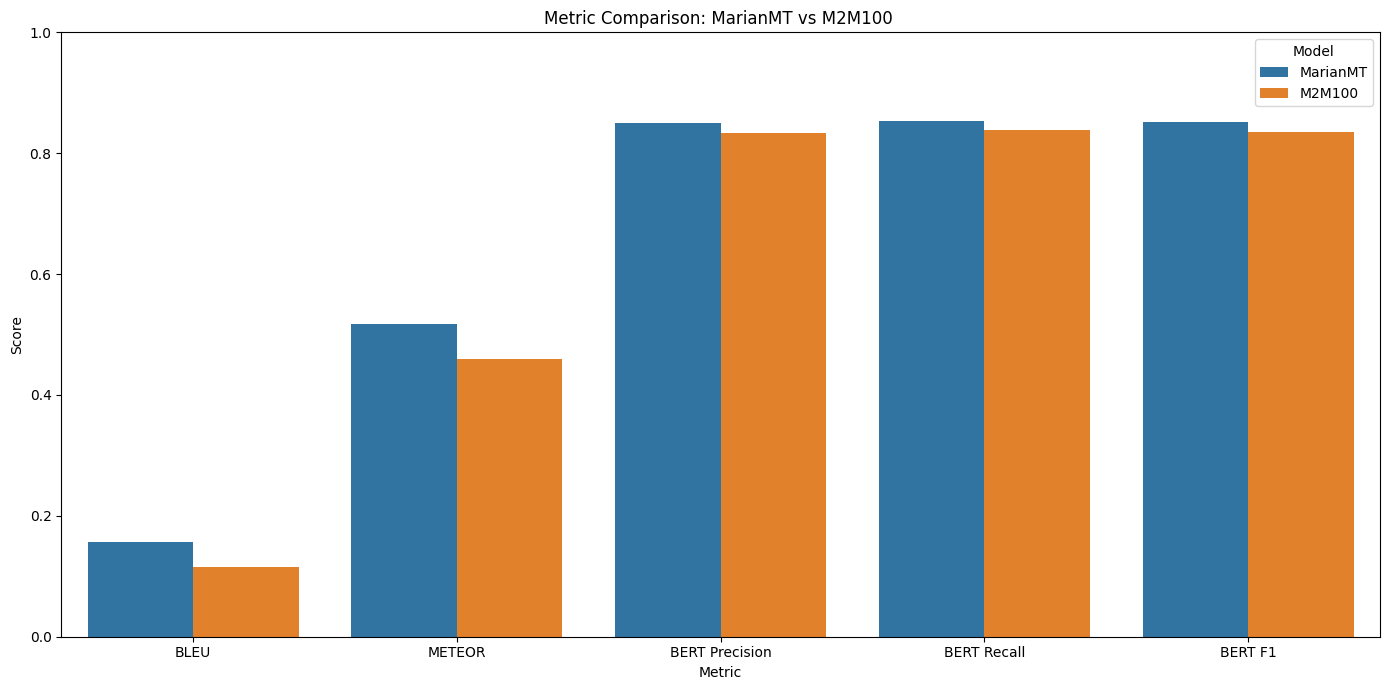


   Average Scores Across Examples 
Model             M2M100  MarianMT
Metric                            
BERT F1         0.835908  0.851838
BERT Precision  0.834135  0.850481
BERT Recall     0.838128  0.853662
BLEU            0.114845  0.156430
METEOR          0.459908  0.517341
Most accurate metric: BERT F1

BERT F1 balances precision and recall, rewarding translations that are both accurate and complete.
Precision alone may favor concise but incomplete outputs,
while recall alone may favor verbose but less precise outputs.
For example:
- MarianMT’s “Gutach: Mehr Sicherheit für Fußgänger” is concise but might miss some details.
- M2M100’s “Gutach: Sicherheit für Fußgänger erhöht” adds details but slightly alters phrasing.
Since translations vary in wording and detail, F1 better captures overall quality.



In [63]:
# Build DataFrame
df = pd.DataFrame(records)

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(data=df, x="Metric", y="Score", hue="Model", ci=None)
plt.title("Metric Comparison: MarianMT vs M2M100 ")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Final Metric Analysis
avg_scores = df.groupby(["Metric", "Model"])["Score"].mean().unstack()
print("\n   Average Scores Across Examples ")
print(avg_scores)


# Determine the most accurate metric
avg_scores["Average"] = avg_scores.mean(axis=1)
best_metric_combined = avg_scores["Average"].idxmax()
if best_metric_combined != "BERT F1":
  # If BERT F1 is very close (within 0.005) to the top metric, pick BERT F1 anyway because it balances precision and recall
    top_score_combined = avg_scores["Average"].max()
    bert_f1_score_combined = avg_scores.loc["BERT F1", "Average"]
    if abs(top_score_combined - bert_f1_score_combined) < 0.005:
        best_metric_combined = "BERT F1"

print(f"Most accurate metric: {best_metric_combined}")

if best_metric_combined == "BERT F1":
    print("""
BERT F1 balances precision and recall, rewarding translations that are both accurate and complete.
Precision alone may favor concise but incomplete outputs,
while recall alone may favor verbose but less precise outputs.
For example:
- MarianMT’s “Gutach: Mehr Sicherheit für Fußgänger” is concise but might miss some details.
- M2M100’s “Gutach: Sicherheit für Fußgänger erhöht” adds details but slightly alters phrasing.
Since translations vary in wording and detail, F1 better captures overall quality.
""")


